In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

2024-11-28 23:31:50.314472: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
# Load the dataset
df = pd.read_csv("storms.csv")
df.head()

,Unnamed: 0,name,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter
0,1,Amy,1975,6,27,0,27.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
1,2,Amy,1975,6,27,6,28.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
2,3,Amy,1975,6,27,12,29.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
3,4,Amy,1975,6,27,18,30.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
4,5,Amy,1975,6,28,0,31.5,-78.8,tropical depression,NaN,25,1012,NaN,NaN


In [ ]:
# Tasks for Data visualization:

# Number of Stroms:
df['name'].nunique()

# Differnet Stroms, Intensity and number 

#...



258

/var/folders/q5/jy008p1n39v3frsp_b689njr0000gn/T/ipykernel_12532/2077858057.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


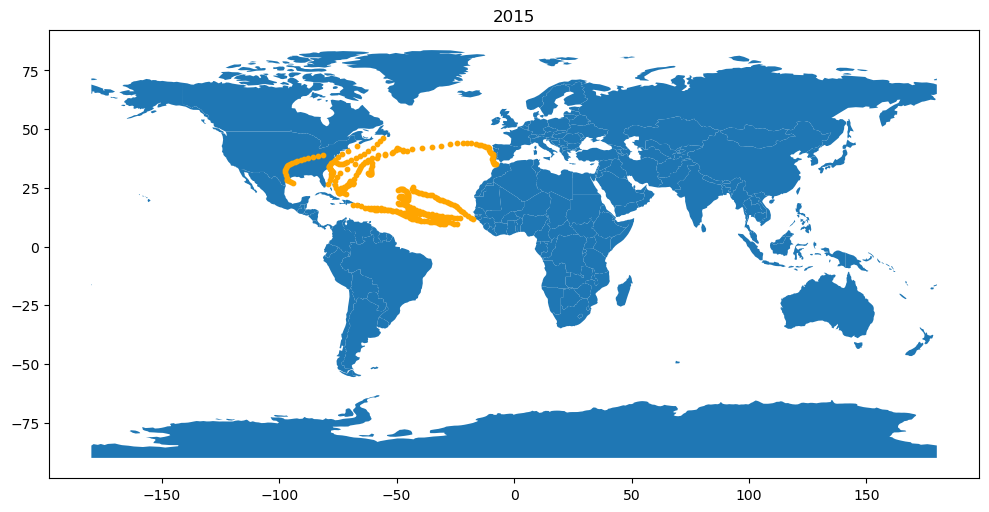

/var/folders/q5/jy008p1n39v3frsp_b689njr0000gn/T/ipykernel_12532/2077858057.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


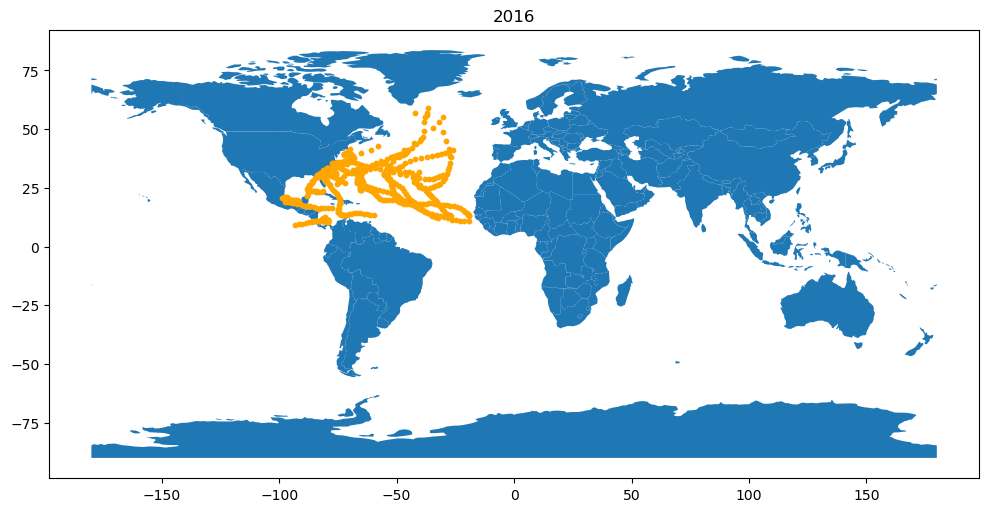

/var/folders/q5/jy008p1n39v3frsp_b689njr0000gn/T/ipykernel_12532/2077858057.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


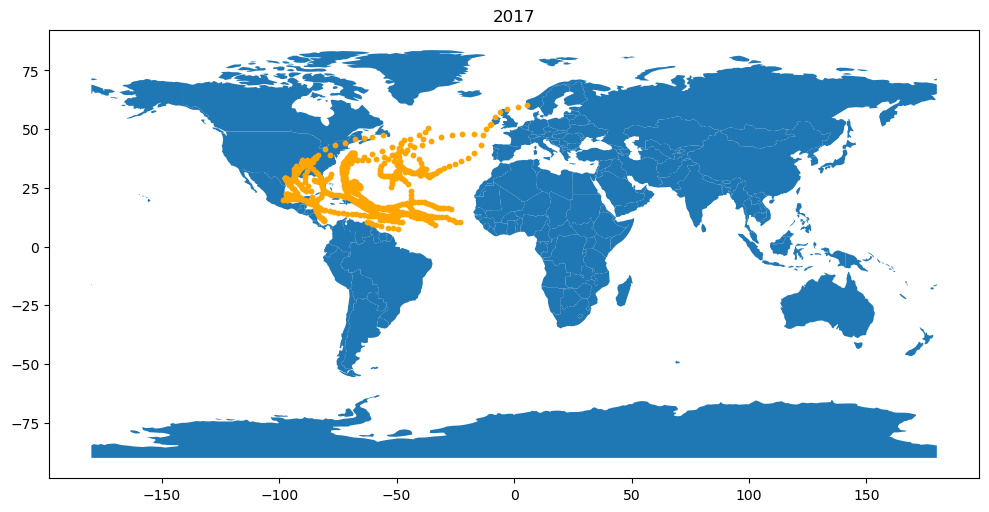

/var/folders/q5/jy008p1n39v3frsp_b689njr0000gn/T/ipykernel_12532/2077858057.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


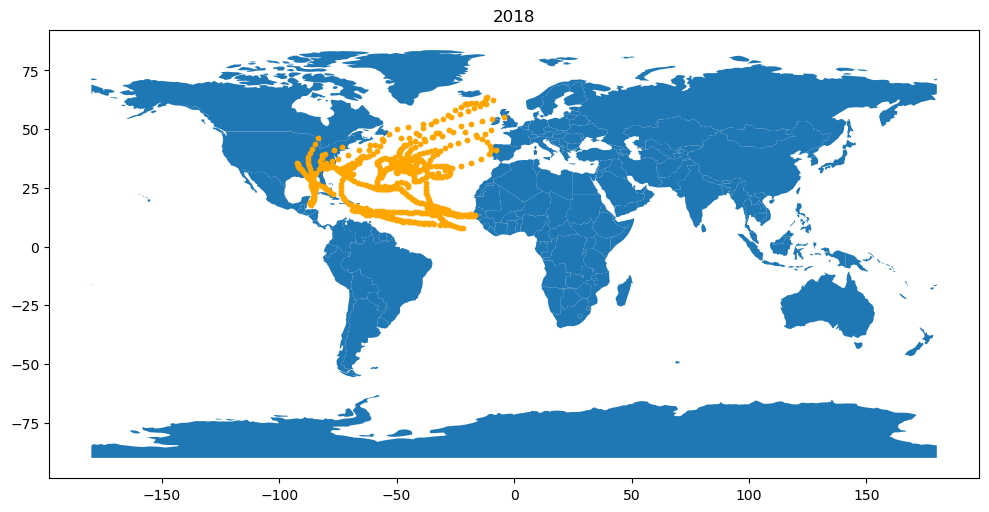

/var/folders/q5/jy008p1n39v3frsp_b689njr0000gn/T/ipykernel_12532/2077858057.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


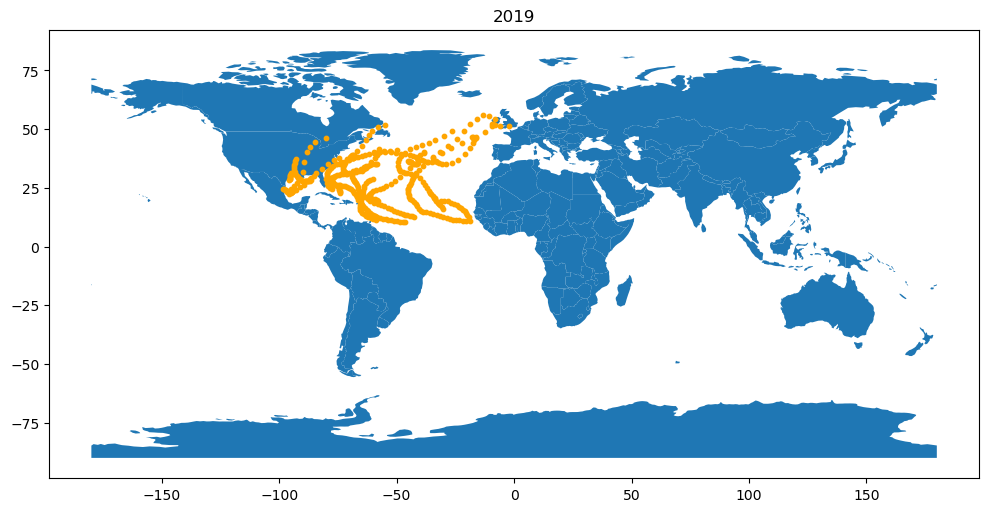

/var/folders/q5/jy008p1n39v3frsp_b689njr0000gn/T/ipykernel_12532/2077858057.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


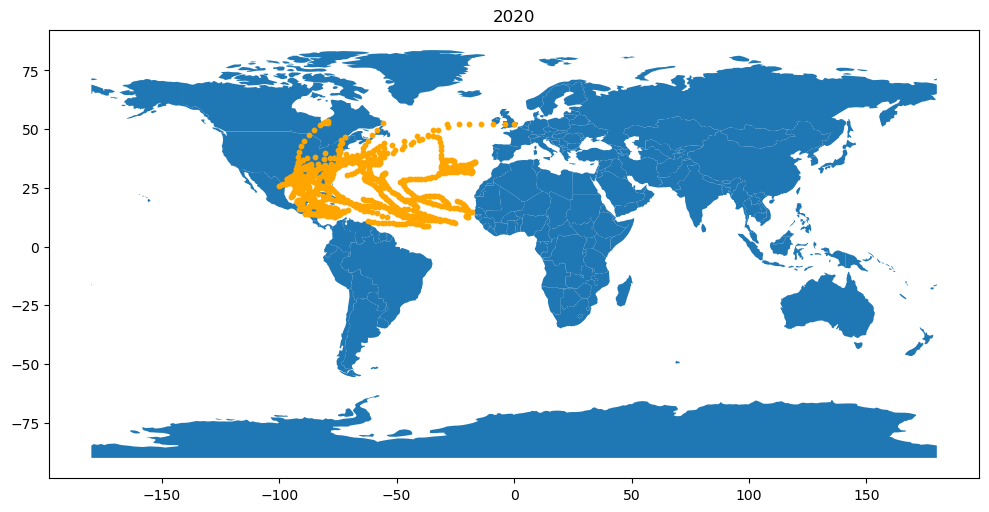

/var/folders/q5/jy008p1n39v3frsp_b689njr0000gn/T/ipykernel_12532/2077858057.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


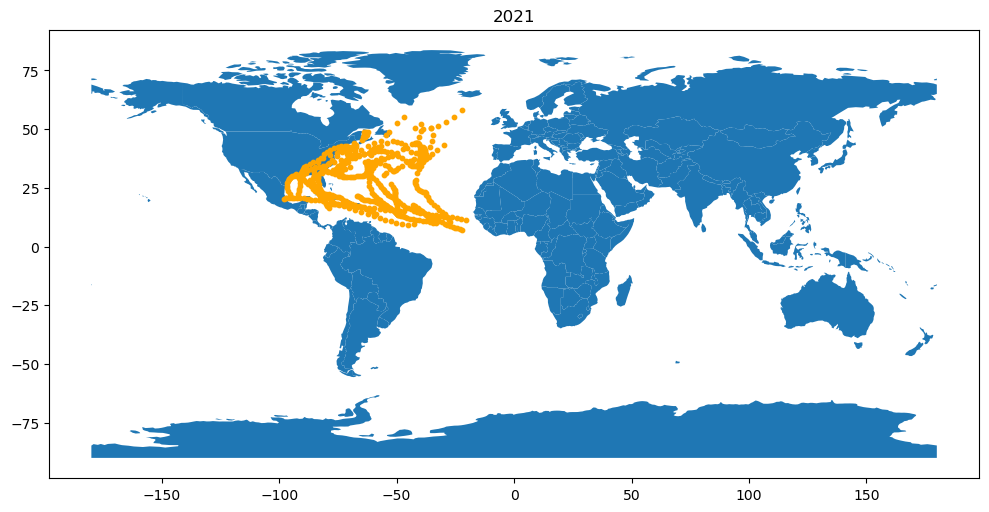

In [10]:
for y in range(2015,2022):
    df0=df[df['year']==y].copy()
    geometry = [Point(xy) for xy in zip(df0['long'], df0['lat'])]
    gdf = GeoDataFrame(df0, geometry = geometry)
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf.plot(ax=world.plot(figsize=(12,12)), color='orange', markersize=10)
    plt.title(str(y))
    plt.show()

# Data Preprocessing 

In [18]:
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.sort_values(by=['name', 'datetime']).reset_index(drop=True)

features = ['lat', 'long']
df = df[['name', 'datetime'] + features]
df.head()

,name,datetime,lat,long
0,AL011993,1993-05-31 12:00:00,21.5,-84.0
1,AL011993,1993-05-31 18:00:00,22.3,-82.0
2,AL011993,1993-06-01 00:00:00,23.2,-80.3
3,AL011993,1993-06-01 06:00:00,24.5,-79.0
4,AL011993,1993-06-01 12:00:00,25.4,-77.5


In [20]:
# Normalize latitude and longitude
scaler = MinMaxScaler()
df[['lat', 'long']] = scaler.fit_transform(df[['lat', 'long']])

# Prepare sequences for each storm
sequences = []
sequence_length = 10  # Use 10 time steps for each input sequence

for name, group in df.groupby('name'):
    data = group[['lat', 'long']].values
    if len(data) > sequence_length:
        for i in range(len(data) - sequence_length):
            sequences.append(data[i:i+sequence_length+1])

sequences = np.array(sequences)
X = sequences[:, :-1, :]  # Input sequence
y = sequences[:, -1, :]   # Target: Next step's lat/long

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')  # 2 outputs: lat and long
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Example prediction
predicted_lat_long = model.predict(X_test[:1])
print("Predicted:", scaler.inverse_transform(predicted_lat_long))
print("Actual:", scaler.inverse_transform(y_test[:1]))

Epoch 1/20


/opt/miniconda3/envs/c_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


415/415 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0246 - mae: 0.1042 - val_loss: 0.0053 - val_mae: 0.0428
Epoch 2/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0061 - mae: 0.0477 - val_loss: 0.0038 - val_mae: 0.0307
Epoch 3/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0042 - mae: 0.0377 - val_loss: 0.0032 - val_mae: 0.0251
Epoch 4/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0035 - mae: 0.0323 - val_loss: 0.0030 - val_mae: 0.0203
Epoch 5/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0030 - mae: 0.0292 - val_loss: 0.0029 - val_mae: 0.0212
Epoch 6/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0032 - mae: 0.0278 - val_loss: 0.0028 - val_mae: 0.0201
Epoch 7/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0030 - mae: 0.0268 - val_loss: 0.0029 - val_mae: 0.0227
Epoch 8/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0029 - mae: 0.0267 - val_loss: 0.0028 - val_mae: 0.0175
Epoch 9/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss:

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate the model
y_pred = model.predict(X_test)

# Inverse transform the predictions and true values to get them back in original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

# Calculate metrics
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Square Error (MSE): {mse:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Mean Absolute Error (MAE): 1.6244
Mean Square Error (MSE): 21.4727
Root Mean Square Error (RMSE): 4.6339
R² Score: 0.9032


In [22]:
from tensorflow.keras.layers import GRU

# Build the GRU model
gru_model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')  # 2 outputs: lat and long
])

gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the GRU model
history_gru = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate the GRU model
loss_gru, mae_gru = gru_model.evaluate(X_test, y_test)
print(f"GRU Model - Test Loss: {loss_gru}, Test MAE: {mae_gru}")

# Example prediction with GRU model
y_pred_gru = gru_model.predict(X_test)

# Inverse transform the predictions and true values to get them back in original scale
y_pred_gru_original = scaler.inverse_transform(y_pred_gru)
y_test_original = scaler.inverse_transform(y_test)

# Calculate metrics for GRU model
mse_gru = mean_squared_error(y_test_original, y_pred_gru_original)
mae_gru = mean_absolute_error(y_test_original, y_pred_gru_original)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_original, y_pred_gru_original)

# Print metrics for GRU model
print(f"GRU Model - Mean Absolute Error (MAE): {mae_gru:.4f}")
print(f"GRU Model - Mean Square Error (MSE): {mse_gru:.4f}")
print(f"GRU Model - Root Mean Square Error (RMSE): {rmse_gru:.4f}")
print(f"GRU Model - R² Score: {r2_gru:.4f}")


Epoch 1/20


/opt/miniconda3/envs/c_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


415/415 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0147 - mae: 0.0780 - val_loss: 0.0048 - val_mae: 0.0473
Epoch 2/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0030 - val_mae: 0.0234
Epoch 3/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0035 - mae: 0.0299 - val_loss: 0.0035 - val_mae: 0.0340
Epoch 4/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0035 - mae: 0.0298 - val_loss: 0.0028 - val_mae: 0.0196
Epoch 5/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0026 - mae: 0.0244 - val_loss: 0.0028 - val_mae: 0.0184
Epoch 6/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0030 - mae: 0.0261 - val_loss: 0.0028 - val_mae: 0.0228
Epoch 7/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0029 - mae: 0.0257 - val_loss: 0.0028 - val_mae: 0.0218
Epoch 8/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0028 - mae: 0.0248 - val_loss: 0.0030 - val_mae: 0.0270
Epoch 9/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss

In [ ]:
# Filter the DataFrame for the storm named 'Amy'
storm_name = "Amy"
amy_data = df[df['name'] == storm_name].sort_values(by=['datetime'])

# Extract the relevant features: latitude and longitude
amy_lat_long = amy_data[['lat', 'long']].values

# Show the first few rows of Amy's data
amy_data.head()


,name,datetime,lat,long
938,Amy,1975-06-27 00:00:00,0.321821,0.246743
939,Amy,1975-06-27 06:00:00,0.337520,0.246743
940,Amy,1975-06-27 12:00:00,0.353218,0.246743
941,Amy,1975-06-27 18:00:00,0.368917,0.246743
942,Amy,1975-06-28 00:00:00,0.384615,0.248371


In [38]:
# Example prediction with GRU model
y_pred_gru = gru_model.predict(amy_data)

# Inverse transform the predictions and true values to get them back in original scale
y_pred_gru_original = scaler.inverse_transform(y_pred_gru)
y_test_original = scaler.inverse_transform(y_test)

ValueError: Invalid dtype: datetime64[ns]

/var/folders/q5/jy008p1n39v3frsp_b689njr0000gn/T/ipykernel_12532/2126928779.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


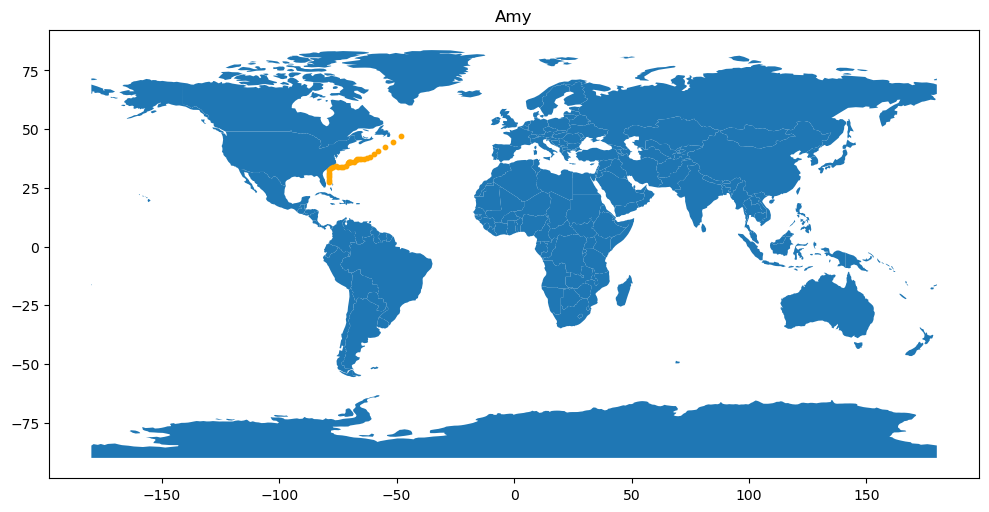

In [37]:
storm = 'Amy'

df0 = df[df['name']==storm].copy()
geometry = [Point(xy) for xy in zip(df0['long'], df0['lat'])]
gdf = GeoDataFrame(df0, geometry = geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(12,12)), color='orange', markersize=10)
plt.title(str(storm))
plt.show()


In [ ]:

for y in range(2015,2022):
    df0=df[df['year']==y].copy()
    geometry = [Point(xy) for xy in zip(df0['long'], df0['lat'])]
    gdf = GeoDataFrame(df0, geometry = geometry)
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf.plot(ax=world.plot(figsize=(12,12)), color='orange', markersize=10)
    plt.title(str(y))
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/opt/miniconda3/envs/c_env/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
